# Clasificación de CIFAR-10 con Pytorch

## Introducción

El dataset CIFAR-10 es un conjunto de 60.000 imágenes a color de 32x32 píxeles, que contienen 10 clases de objetos.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

## Preparación del entorno

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

In [2]:
np.random.seed(42)
torch.manual_seed(42)

# Determinar el dispositivo (GPU si está disponible, si no CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True # Elige el mejor algoritmo acorde al hardware
    torch.cuda.manual_seed_all(42) # Inicializa la semilla para la GPU
else:
    device = torch.device("cpu")
    
print(f"\nUsando dispositivo: {device}")


num_workers = os.cpu_count() // 2 # Número de workers. La mitad de los núcleos disponibles (heuristico común)


Usando dispositivo: cuda


## Carga y preparación de datos

Utilizaremos como modelo de referencia el del [tutorial oficial de PyTorch para la clasificación en CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) y buscaremos mejorar su rendimiento.

La salida de los *datasets* de torchvision son imágenes PILImage de rango \[0,1\]. el tutorial de base las transforma en Tensors de rango normalizado \[-1, 1\].

> [!TIP]
> El tutorial emplea (0.5, 0.5, 0.5) tanto en la media como en la desviación estándar porque, tras convertir los píxeles a [0,1] con ToTensor(), esta normalización centra los valores en cero y los escala para que queden en el rango simétrico [-1, +1], facilitando la convergencia de la red. Además, al usar el mismo valor en los tres canales (R, G y B), el cálculo es trivial y uniforme, sin necesidad de medir las estadísticas reales del conjunto de datos (aunque estas pueden calcularse para un ajuste más fino). En definitiva, es un “atajo” práctico que simplifica el preprocesado y funciona bien en la mayoría de los ejemplos y tutoriales de CIFAR-10.


Se modifica el preprocesado para calcular la media y la desviación estándar de los datos de entrenamiento.

In [3]:
batch_size = 32

temp_ds = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transforms.ToTensor() # Solo se convierte a tensor
)
temp_loader = torch.utils.data.DataLoader(
    temp_ds, batch_size=batch_size, shuffle=False, num_workers=2
)

#  Acumulamos sumas y sumas de cuadrados por canal:
sum_ = torch.zeros(3)
sum_sq = torch.zeros(3)
n = 0
for images, _ in temp_loader:
    # images: [b, 3, 32, 32] en rango [0.,1.]
    b, c, h, w = images.shape # b: batch size, c: number of channels, h: height, w: width
    images = images.view(b, c, -1) # flatten the image to  [b, 3, 1024]
    sum_   += images.sum(dim=[0,2])        # suma de cada canal
    sum_sq += (images ** 2).sum(dim=[0,2]) # suma de cuadrados
    n     += b * h * w

# Media y desviación estándar por canal:
mean = sum_   / n
std  = torch.sqrt(sum_sq / n - mean**2)
print('CIFAR-10 mean:', mean)
print('CIFAR-10 std: ', std)

100%|██████████| 170M/170M [01:53<00:00, 1.51MB/s] 


CIFAR-10 mean: tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 std:  tensor([0.2470, 0.2435, 0.2616])


> [!IMPORTANT]  
> `torchvision.datasets.CIFAR10`descarga los datos en el directorio `./data` si no existe. Este directorio debe ignorarse del repositorio ya que ocupa demasiado espacio para subirlo a GitHub (y precisamente ya tenemos el código para descargarlo desde otro servidor). Para esto es importante haberlo declarado en el fichero [`.gitignore`](./.gitignore).

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tuple(mean.tolist()), tuple(std.tolist()))
])

fulltrainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Separación en conjuntos de entrenamiento y validación

train_size = int(0.8 * len(fulltrainset))
valid_size = len(fulltrainset) - train_size
trainset, validset = torch.utils.data.random_split(fulltrainset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

fulltrainset.classes # Las clases ya están definidas en el dataset

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Definición de funciones de entrenamiento y validación

Existen diferentes metodologías de entrenamiento y evaluación.
- Enfoque 1: Entrenar completamente, luego evaluar (funciones separadas)
    - Simplicidad: Código más simple y fácil de entender.
    - Velocidad: Más rápido si solo te interesa el resultado final.
    - Menor sobrecarga: No interrumpe el proceso de entrenamiento.
    - Adecuado para datasets grandes: Cuando la evaluación es costosa.
- Enfoque 2: Evaluar después de cada época (función integrada)
    - Monitoreo del progreso: Puedes ver cómo mejora el modelo durante el entrenamiento.
    - Detección temprana de problemas: Identificar *overfitting/underfitting* a tiempo.
    - *Early stopping*: Puedes detener el entrenamiento cuando deja de mejorar.
    - Guardado del mejor modelo: Guardar el modelo con mejor rendimiento en validación.
    
En este caso usamos el enfoque 2 que permite comparar diferentes arquitecturas observando el progreso a través de las epochs. Así visualizamos no solo los resultados finales si no la curva de aprendizaje.

Se definen las funciones de entrenamiento y evaluación para poder reutilizarlas en el entrenamiento de diferentes arquitecturas.

In [5]:
from utils.training_functions import train_model, evaluate_model, train_final_model
from utils.plot_functions import plot_metrics, plot_class_accuracy

## *Baseline*

Starting training on 'cuda' for 15 epochs with batch size 32...


Epoch 1/15 completed: Train Loss: 2.1474, Train Acc: 21.05%, Val Loss: 1.9135, Val Acc: 31.60%


Epoch 2/15 completed: Train Loss: 1.7629, Train Acc: 36.24%, Val Loss: 1.6314, Val Acc: 41.48%


Epoch 3/15 completed: Train Loss: 1.5539, Train Acc: 43.29%, Val Loss: 1.5009, Val Acc: 45.36%


Epoch 4/15 completed: Train Loss: 1.4351, Train Acc: 47.99%, Val Loss: 1.4390, Val Acc: 47.70%


Epoch 5/15 completed: Train Loss: 1.3606, Train Acc: 50.88%, Val Loss: 1.4031, Val Acc: 49.92%


Epoch 6/15 completed: Train Loss: 1.3003, Train Acc: 53.38%, Val Loss: 1.3082, Val Acc: 53.21%


Epoch 7/15 completed: Train Loss: 1.2432, Train Acc: 55.59%, Val Loss: 1.2828, Val Acc: 54.84%


Epoch 8/15 completed: Train Loss: 1.1973, Train Acc: 57.34%, Val Loss: 1.2661, Val Acc: 55.51%


Epoch 9/15 completed: Train Loss: 1.1622, Train Acc: 58.70%, Val Loss: 1.2063, Val Acc: 57.66%


Epoch 10/15 completed: Train Loss: 1.1228, Train Acc: 59.95%, Val Loss: 1.2167, Val Acc: 57.13%


Epoch 11/15 completed: Train Loss: 1.0910, Train Acc: 61.40%, Val Loss: 1.2050, Val Acc: 57.86%


Epoch 12/15 completed: Train Loss: 1.0555, Train Acc: 62.46%, Val Loss: 1.1543, Val Acc: 59.73%


Epoch 13/15 completed: Train Loss: 1.0251, Train Acc: 63.65%, Val Loss: 1.1441, Val Acc: 60.13%


Epoch 14/15 completed: Train Loss: 0.9953, Train Acc: 64.79%, Val Loss: 1.1366, Val Acc: 60.49%


Epoch 15/15 completed: Train Loss: 0.9711, Train Acc: 65.67%, Val Loss: 1.1242, Val Acc: 60.90%

Training completed after finishing all epochs.
Total training time: 68.65 seconds


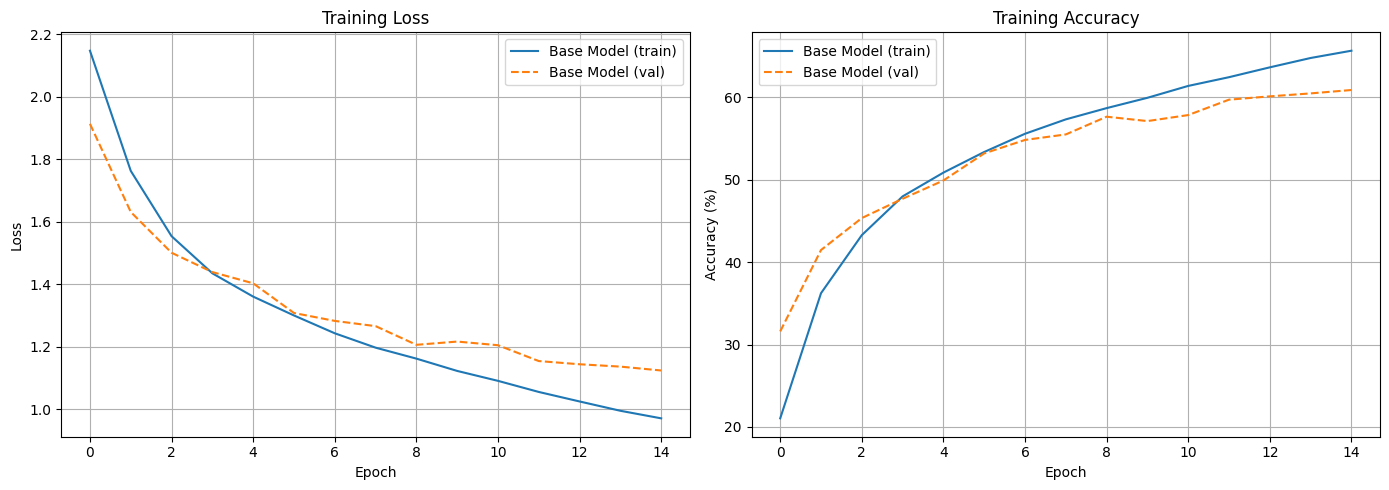

In [6]:
# Inicializar el modelo base
from models.baseline import Net
base_model = Net()

# Definir criterio de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

# Entrenar el modelo base
base_metrics = train_model(
    base_model, 
    trainset,
    validset,
    batch_size,
    criterion,
    optimizer,
    epochs=15,
    device=device,
    num_workers=num_workers
)

plot_metrics([base_metrics], ['Base Model'])

Se puede observar *overfitting* al incrementarse la accuracy de entrenamiento mucho más que la de validación a partir de la época 10 (aproximadamente).

## Mejora

Para evitar el *overfitting* se puede usar regularización, dropout, etc.

Starting training on 'cuda' for 15 epochs with batch size 32...


Epoch 1/15 completed: Train Loss: 1.4981, Train Acc: 45.44%, Val Loss: 1.1731, Val Acc: 58.00%


Epoch 2/15 completed: Train Loss: 1.1358, Train Acc: 59.91%, Val Loss: 0.9168, Val Acc: 67.50%


Epoch 3/15 completed: Train Loss: 0.9754, Train Acc: 65.72%, Val Loss: 0.8068, Val Acc: 71.71%


Epoch 4/15 completed: Train Loss: 0.8631, Train Acc: 70.12%, Val Loss: 0.7280, Val Acc: 74.51%


Epoch 5/15 completed: Train Loss: 0.7742, Train Acc: 73.20%, Val Loss: 0.6976, Val Acc: 76.01%


Epoch 6/15 completed: Train Loss: 0.7069, Train Acc: 75.56%, Val Loss: 0.6921, Val Acc: 76.37%


Epoch 7/15 completed: Train Loss: 0.6453, Train Acc: 77.93%, Val Loss: 0.6522, Val Acc: 77.86%


Epoch 8/15 completed: Train Loss: 0.5903, Train Acc: 79.57%, Val Loss: 0.6379, Val Acc: 78.32%


Epoch 9/15 completed: Train Loss: 0.5539, Train Acc: 80.92%, Val Loss: 0.6119, Val Acc: 79.70%


Epoch 10/15 completed: Train Loss: 0.5100, Train Acc: 82.36%, Val Loss: 0.5664, Val Acc: 81.43%


Epoch 11/15 completed: Train Loss: 0.4739, Train Acc: 83.54%, Val Loss: 0.5854, Val Acc: 81.04%


Epoch 12/15 completed: Train Loss: 0.4444, Train Acc: 84.75%, Val Loss: 0.5694, Val Acc: 81.36%


Epoch 13/15 completed: Train Loss: 0.4079, Train Acc: 85.77%, Val Loss: 0.6268, Val Acc: 80.81%


Epoch 14/15 completed: Train Loss: 0.3838, Train Acc: 86.79%, Val Loss: 0.5911, Val Acc: 81.86%


Epoch 15/15 completed: Train Loss: 0.3555, Train Acc: 87.56%, Val Loss: 0.6264, Val Acc: 81.15%

Training completed after finishing all epochs.
Total training time: 129.00 seconds


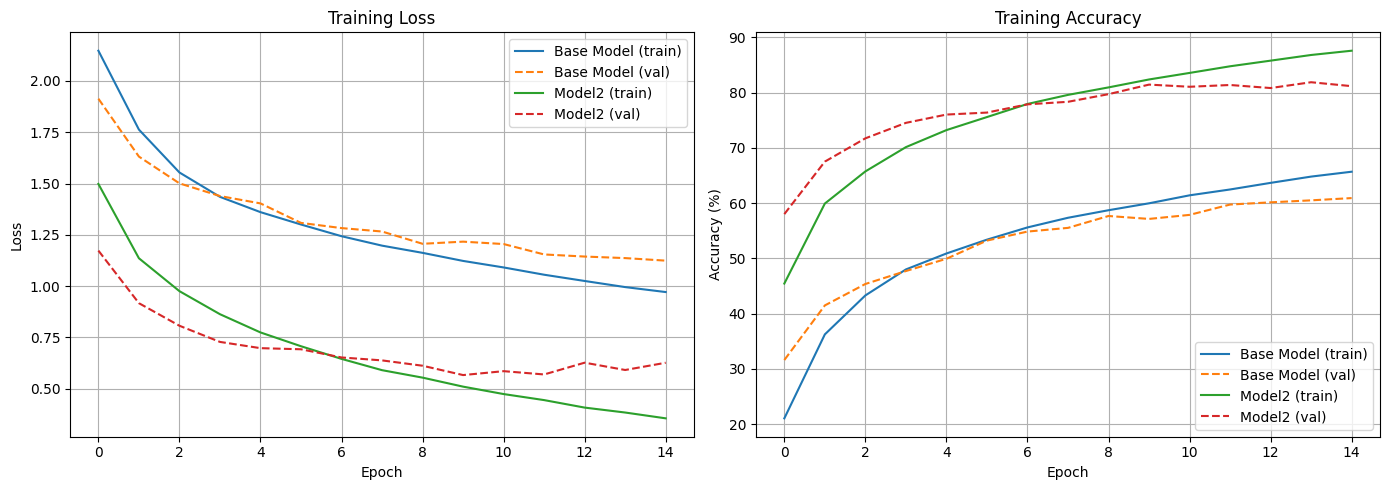

In [7]:
from models.mejorado import ImprovedCNN
model2 = ImprovedCNN()

# Definir criterio de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)

# Entrenar el modelo base
metrics2 = train_model(
    model2, 
    trainset,
    validset,
    32,
    criterion,
    optimizer,
    epochs=15,
    device=device,
    num_workers=num_workers
)

### Visualización de las métricas
plot_metrics([base_metrics, metrics2], ['Base Model', "Model2"])

## Evaluación en test y almacenamiento del modelo final

Habiendo elegido lanueva arquitectura propuesta como modelo final, reentrenamos con todo el conjunto de entrenamiento.

In [8]:
model2 = ImprovedCNN() # Reinicializamos el modelo (aunque habría otras estrategias)
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)

final_metrics = train_final_model(
    model2,
    fulltrainset,
    batch_size,
    criterion,
    optimizer,
    epochs=10, # A partir de aquí hemos visto que empezaba a haber overfitting
    device=device,
    num_workers=num_workers,
)

Starting final training on 'cuda' for 10 epochs with batch size 32...


Epoch 1/10 => Train Loss: 1.4162, Train Acc: 48.6680


Epoch 2/10 => Train Loss: 1.0391, Train Acc: 63.3600


Epoch 3/10 => Train Loss: 0.8880, Train Acc: 69.3060


Epoch 4/10 => Train Loss: 0.7774, Train Acc: 73.1720


Epoch 5/10 => Train Loss: 0.6992, Train Acc: 76.1780


Epoch 6/10 => Train Loss: 0.6305, Train Acc: 78.4200


Epoch 7/10 => Train Loss: 0.5793, Train Acc: 80.3220


Epoch 8/10 => Train Loss: 0.5321, Train Acc: 81.6760


Epoch 9/10 => Train Loss: 0.4873, Train Acc: 83.1880


Epoch 10/10 => Train Loss: 0.4538, Train Acc: 84.2140

Final training completed.
Total final training time: 94.65 seconds


Test Loss: 0.5851, Test Accuracy: 80.79%


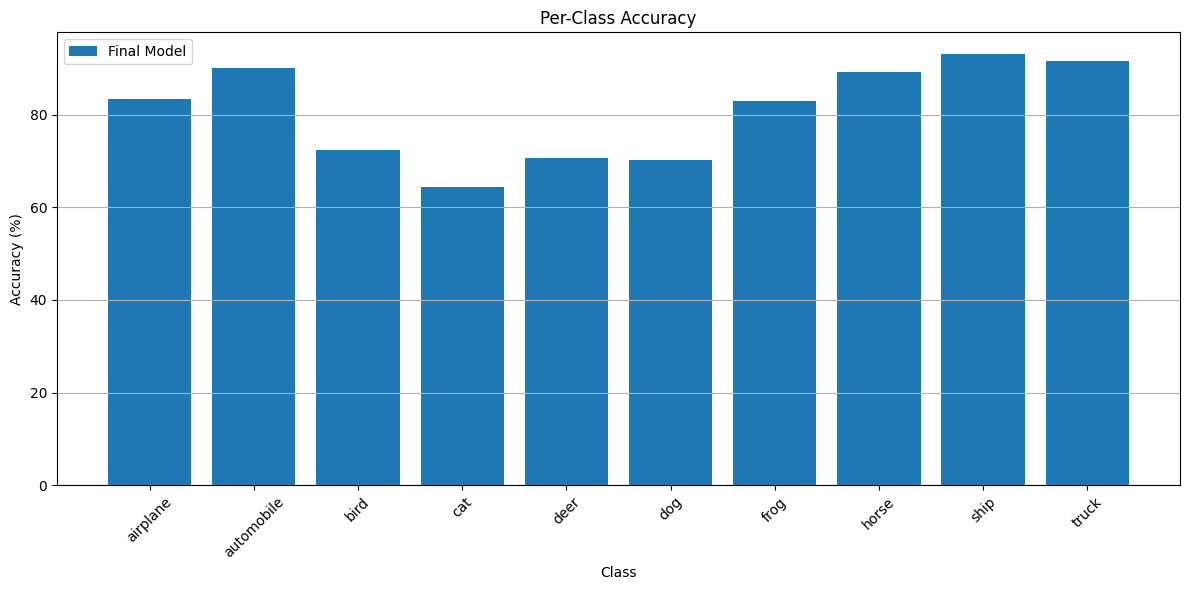

In [9]:
# Evaluate the final model on the test set
test_results = evaluate_model(model2, testloader, criterion, device) # Capture the full results
test_loss = test_results['loss']
test_acc = test_results['accuracy']
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Now plot the class accuracy using the captured results
plot_class_accuracy(
    results_list=[test_results],  # Pass the results dictionary in a list
    model_names=['Final Model'],  # Provide a name for the model
    class_names=testset.classes
)

Una vez elegido y entrenado el modelo, podemos almacenarlo para desplegarlo.

In [10]:
PATH = './cifar_net.pth'
torch.save(model2.state_dict(), PATH)